,PVA_COUNT_OF_EACH_DRUG_FAMILY,NAME_OF_NDC,Total Count of NDC,Percentage of NON_PVA of NDC
0,0,"""HELIXATE FS 1,000 UNIT VIAL""",1,100.00
1,39,OXYCODONE-ACETAMINOPHEN 10-325,5942,99.34
2,168,ELIQUIS 5 MG TABLET,2762,93.92
3,9,NORCO 10-325 TABLET,145,93.79
4,183,ADVAIR 250-50 DISKUS,2585,92.92
5,289,PROVENTIL HFA 90 MCG INHALER,2860,89.90
6,258,LYRICA 75 MG CAPSULE,2416,89.32
7,246,BUPRENORPHIN-NALOXON 8-2 MG SL,2301,89.31


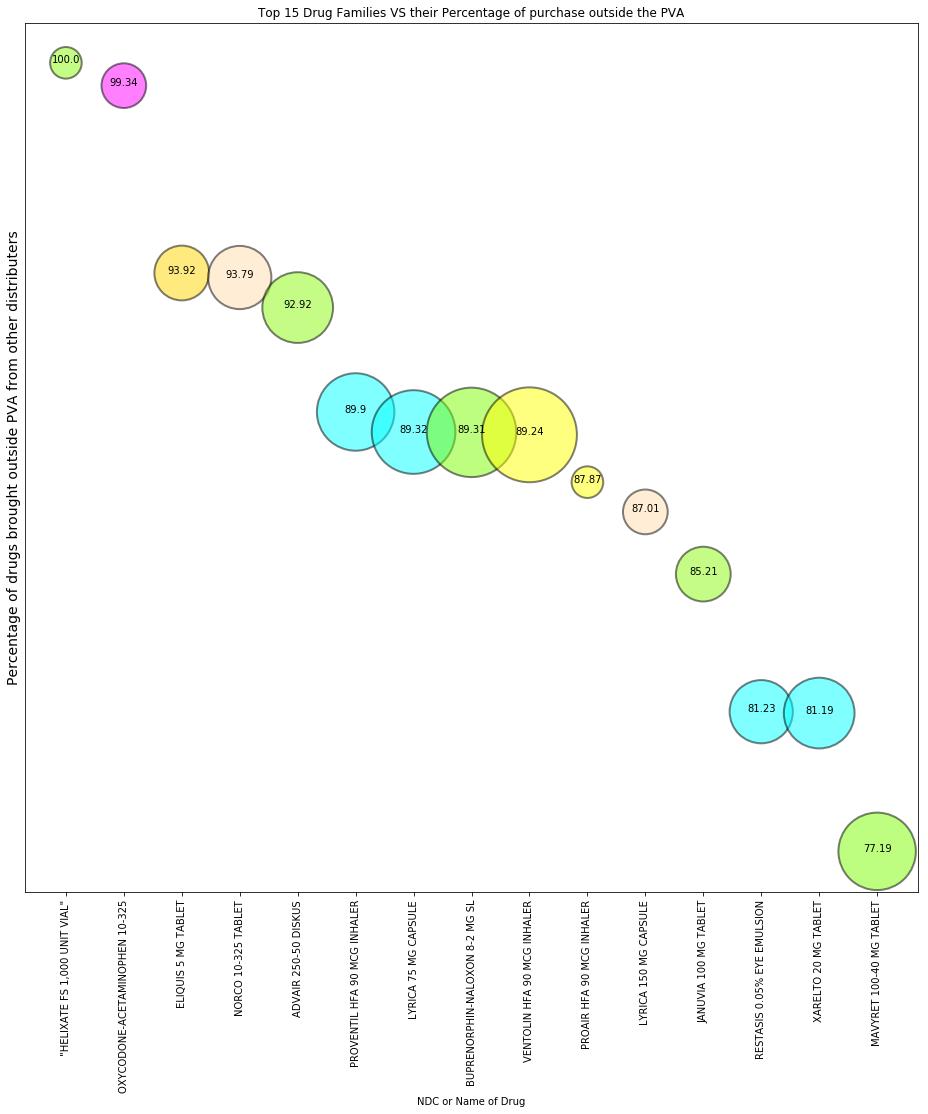

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display,display_html
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(criterion='entropy',n_estimators=10,random_state=0)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
df= pd.read_csv('AIS datasheet.csv')
listOfNamesOfNDC=['PHRMCY_NAME','BUY_GRP_NAM','NDC_DESC','DSPN_QTY_NDC_1WK','PURCH_QTY_NDC_1WK_MTRC','DSPN_QTY_NDC_4WKS','PURCH_QTY_NDC_4WKS_MTRC','DSPN_QTY_NDC_13WKS','PURCH_QTY_NDC_13WKS_MTRC','DSPN_QTY_NDC_26WKS','PURCH_QTY_NDC_26WKS_MTRC','DSPN_QTY_GCN_1WK','PURCH_QTY_GCN_1WK_MTRC','DSPN_QTY_GCN_4WKS','PURCH_QTY_GCN_4WKS_MTRC','DSPN_QTY_GCN_13WKS','PURCH_QTY_GCN_13WKS_MTRC','DSPN_QTY_GCN_26WKS','PURCH_QTY_GCN_26WKS_MTRC']
df1= df[listOfNamesOfNDC]
Xdf1=df1.iloc[:,2:20].values
Xdf1[:,0] = lbl.fit_transform(Xdf1[:,0])
Y1=[]
dictFinal=dict()
dictNew=dict()
index=0
dfNew=df1['NDC_DESC'].drop_duplicates(inplace=False)
for each in dfNew:
    dictNew[index] = each
    index+=1
k=0
totalCount=pd.DataFrame()
while k < index:
    listN=[]
    for each in df1.values:
        if each[2] == dictNew[k]:
            listN.append(each)
    a= np.array(listN)
    e=pd.DataFrame(a,columns=listOfNamesOfNDC)
    X= e.iloc[:,2:20]
    isPVA=0
    for i in range(0,X.shape[0]):
        count=0
        temp= X.iloc[i,:].values
        for i in range(1,len(temp),2):
            if abs(temp[i]-temp[i+1]) >50:
                count+=1
        if count ==0:
            Y1.append('PVA')
            isPVA+=1
        else:
            Y1.append('NON_PVA')
    dictFinal[isPVA] = dictNew[k]
    k+=1
a=sorted(dictFinal.items(),key= itemgetter(0),reverse=True)
#print('aaa: ',a)
keys=pd.DataFrame()
values=pd.DataFrame()
dtCombined=pd.DataFrame()
Ydf1 = np.array(Y1)
rf.fit(Xdf1,Ydf1)
totalCount = pd.DataFrame(df['NDC_DESC'].value_counts())
totalCount.reset_index(drop=False,inplace=True)
totalCount.columns= ['NAME_OF_NDC','Total Count of NDC']
#display(totalCount)
for each in a:
    keys = pd.concat([keys,pd.DataFrame([each[0]])],axis=0)
    values = pd.concat([values,pd.DataFrame([each[1]])],axis=0)
table_Feature_Importance=pd.DataFrame(rf.feature_importances_,index=df1.iloc[:,2:20].columns,columns=['importances']).sort_values('importances',ascending=False)
#display(table_Feature_Importance)
dtCombined=pd.concat([keys,values],axis=1)
dtCombined.columns=['PVA_COUNT_OF_EACH_DRUG_FAMILY','NAME_OF_NDC']
#display(dtCombined)
dtMerged = pd.merge(dtCombined,totalCount, on='NAME_OF_NDC',how='inner')
dtMerged['Percentage of NON_PVA of NDC'] = round((((dtMerged['Total Count of NDC']-dtMerged['PVA_COUNT_OF_EACH_DRUG_FAMILY'])/dtMerged['Total Count of NDC']) * 100),2)
dtMerged = dtMerged.sort_values(by='Percentage of NON_PVA of NDC',ascending=False).reset_index(drop=True)
display(dtMerged[0:8])
color=np.arange(1,10,1)
ax = plt.figure(figsize=(16,16))

ax=plt.scatter(x=dtMerged['NAME_OF_NDC'][0:15],y=dtMerged['Percentage of NON_PVA of NDC'][0:15],
            c=['#8BFA0D','#FF00FF','#FFD700','#FFDEAD','#8BFA0D','#00FFFF','#00FFFF',
             '#7CFC00','#FFFF00','#FFFF00','#FFDEAD','#8BFA0D','#00FFFF','#00FFFF',
             '#7CFC00'],s=color*1000,alpha=0.50,edgecolors='black',linewidth=2)
#plt.legend(loc='best')
plt.tick_params(labelleft=False,left=False)
plt.xticks(rotation=90)
#plt.box(False)
plt.ylabel('Percentage of drugs brought outside PVA from other distributers',fontsize=14 )
plt.xlabel('NDC or Name of Drug')
plt.title('Top 15 Drug Families VS their Percentage of purchase outside the PVA')
for i, value in enumerate(dtMerged['Percentage of NON_PVA of NDC'][0:15]):
    #plt.text(i-0.15,value,str(value),color='Black',fontsize=10)
    plt.annotate(str(value),xy=(i,value),ha='center')
plt.show()
#plt.pie([keys[0],keys[1],keys[2],keys[3],keys[4]],labels=[values[0],values[1],values[2],values[3],values[4]],autopct='%.2f',explode=(0.06,0.06,0.06,0.06,0.06))
#plt.show()

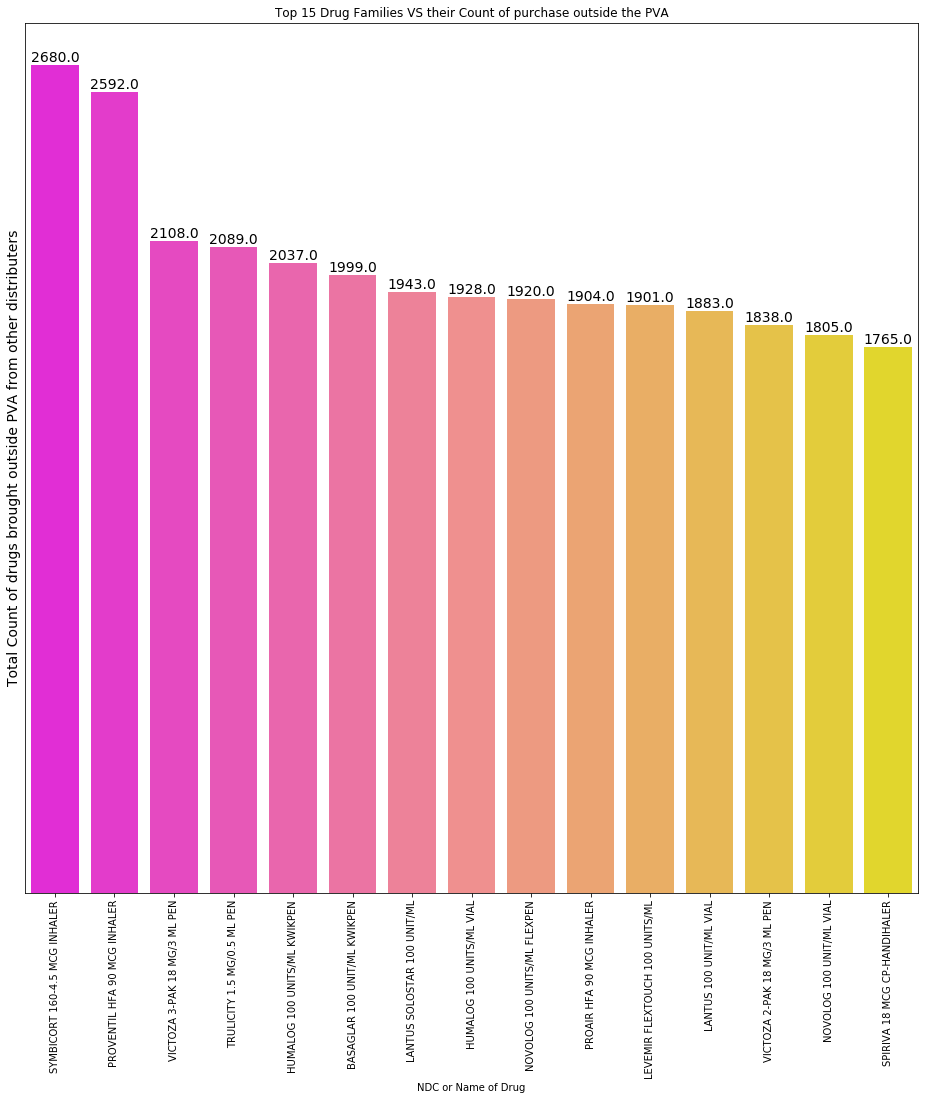

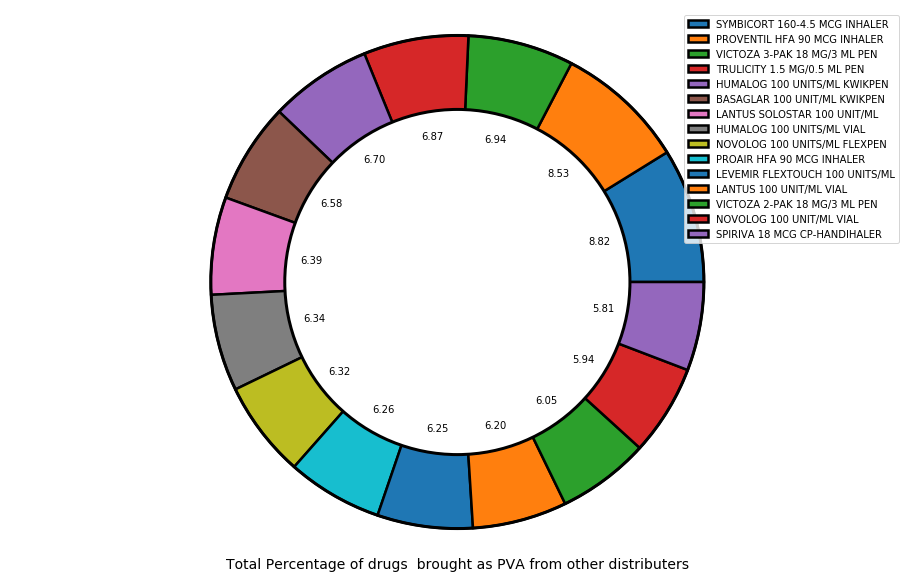

In [494]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv('AIS datasheet.csv')
df.head(2)
from IPython.display import display

def func(value):
    pvaSeries=pd.Series()
    
    value['newValue'] =(value[['DSPN-PURCHASE_1WK','DSPN-PURCHASE_4WKS','DSPN-PURCHASE_13WKS','DSPN-PURCHASE_26WKS']].sum(axis=1))/4
    pvaSeries = pvaSeries.append(pd.Series(['Yes' if each < 50  else 'No'  for each in value['newValue']]))
    PVAStatus = pd.concat([pd.DataFrame(value['NDC_DESC'].unique()),pd.DataFrame(pvaSeries.value_counts()).transpose()],axis=1)
    #display(PVAStatus)
    return(PVAStatus)

def func1():
    overAllPVA=pd.DataFrame() 
    for key,value in df.groupby('NDC_DESC'):
        PVAstatus= pd.Series()

        end=['PHRMCY_NAME','BUY_GRP_NAM','NDC_DESC','DSPN_QTY_NDC_1WK','PURCH_QTY_NDC_1WK_MTRC','DSPN_QTY_NDC_4WKS','PURCH_QTY_NDC_4WKS_MTRC','DSPN_QTY_NDC_13WKS','PURCH_QTY_NDC_13WKS_MTRC','DSPN_QTY_NDC_26WKS','PURCH_QTY_NDC_26WKS_MTRC']
        value = value.loc[:,end]
        value['DSPN-PURCHASE_1WK']=abs(value['PURCH_QTY_NDC_1WK_MTRC']-value['DSPN_QTY_NDC_1WK'])
        value['DSPN-PURCHASE_4WKS']=abs(value['PURCH_QTY_NDC_4WKS_MTRC']-value['DSPN_QTY_NDC_4WKS'])
        value['DSPN-PURCHASE_13WKS']=abs(value['PURCH_QTY_NDC_13WKS_MTRC']-value['DSPN_QTY_NDC_13WKS'])
        value['DSPN-PURCHASE_26WKS']=abs(value['PURCH_QTY_NDC_26WKS_MTRC']-value['DSPN_QTY_NDC_26WKS'])
        PVAstatus= func(value)
        overAllPVA = pd.concat([overAllPVA,PVAstatus],axis=0,sort=True)
        '''PVAstatus.reset_index(drop=True,inplace=True)
        PVAstatus.rename("PVAStatus",inplace=True)
        value.reset_index(drop=True,inplace=True)
        value= pd.concat([value,pd.DataFrame([PVAstatus]).transpose()],axis=1)'''
        #display(value[['PHRMCY_NAME','BUY_GRP_NAM','NDC_DESC','DSPN-PURCHASE_1WK','DSPN-PURCHASE_4WKS','DSPN-PURCHASE_13WKS','DSPN-PURCHASE_26WKS','PVAStatus']])
    overAllPVA = overAllPVA.fillna(0)
    overAllPVA.columns=['Name of The drug','Total Count of Drug Being PVA for Pharmacies','Total Count of Drug Being Non-PVA for Phramacies']
    overAllPVA.sort_values(by=['Total Count of Drug Being Non-PVA for Phramacies'],ascending=False,inplace=True)
    return(overAllPVA) 

def visual1():
    overAllPVA = func1()
    color=np.arange(1,10,1)
    ax = plt.figure(figsize=(16,16))
    ax=sns.barplot(x=overAllPVA['Name of The drug'][0:15],y=overAllPVA['Total Count of Drug Being Non-PVA for Phramacies'][0:15],palette='spring')
    '''ax=plt.scatter(x=overAllPVA['Name of The drug'][0:15],y=overAllPVA['Total Count of Drug Being Non-PVA for Phramacies'][0:15],
                c=['#8BFA0D','#FF00FF','#FFD700','#FFDEAD','#8BFA0D','#00FFFF','#00FFFF',
                 '#7CFC00','#FFFF00','#FFFF00','#FFDEAD','#8BFA0D','#00FFFF','#00FFFF',
                 '#7CFC00'],s=color*1000,alpha=0.50,edgecolors='black',linewidth=2)'''
    #plt.legend(loc='best')
    plt.tick_params(labelleft=False,left=False)
    plt.xticks(rotation=90)
    #plt.box(False)
    plt.ylabel('Total Count of drugs brought outside PVA from other distributers',fontsize=14 )
    plt.xlabel('NDC or Name of Drug')
    plt.title('Top 15 Drug Families VS their Count of purchase outside the PVA')
    for i, value in enumerate(overAllPVA['Total Count of Drug Being Non-PVA for Phramacies'][0:15]):
        #plt.text(i-0.15,value,str(value),color='Black',fontsize=10)
        plt.annotate(str(value),xy=(i,value+10),ha='center',fontsize=14)
    plt.show() 
    plt.show()
    plt.figure(figsize=(16,10))
    plt.pie(x=overAllPVA['Total Count of Drug Being Non-PVA for Phramacies'][0:15],autopct='%.2f',wedgeprops={'linewidth':2.5,'edgecolor':'black'})
    C=plt.Circle((0,0),0.70,fc='white',color='black',linewidth=3.0)
    COutside=plt.Circle((0,0),1,fill=False,edgecolor='black',linewidth=3.0)
    f=plt.gcf()
    f.gca().add_artist(C)
    f.gca().add_patch(COutside)
    plt.axis('equal')
    plt.legend(labels=overAllPVA['Name of The drug'][0:15],loc='best')
    plt.xlabel('Total Percentage of drugs  brought as PVA from other distributers',fontsize=14)
    plt.show()
    ######
visual1()



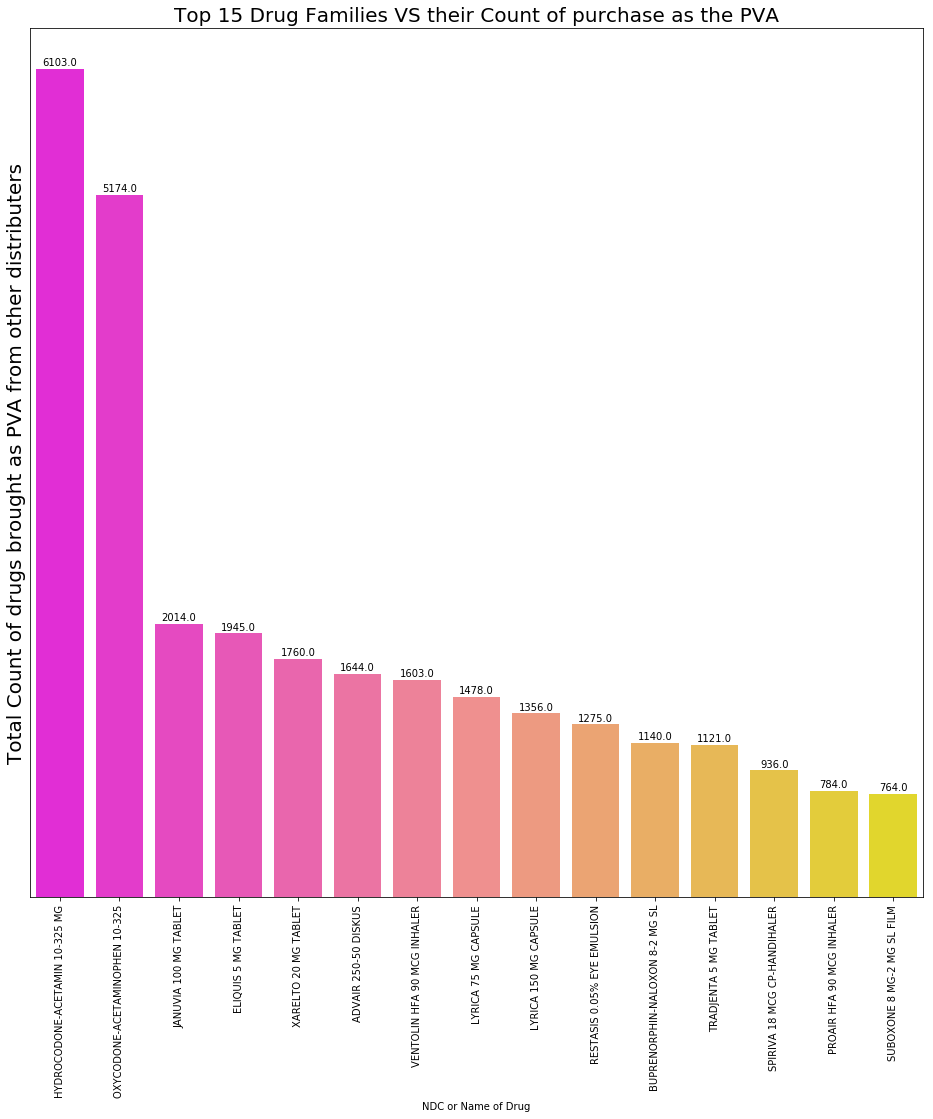

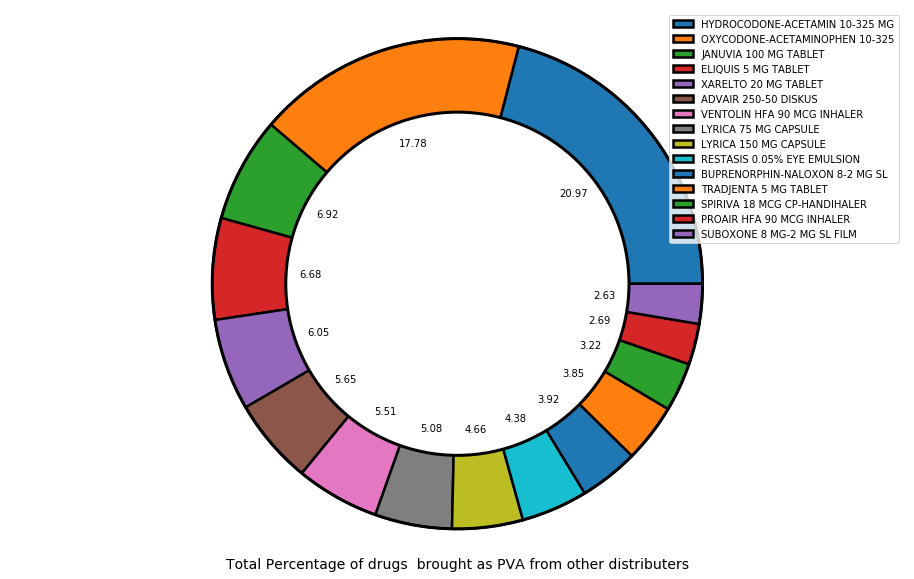

In [493]:
def visual2():
    overAllPVA= func1()
    overAllPVA.sort_values(by=['Total Count of Drug Being PVA for Pharmacies'],ascending=False,inplace=True)
    #display(overAllPVA)    
    color=np.arange(1,10,1)
    ax = plt.figure(figsize=(16,16))

    ax=sns.barplot(x=overAllPVA['Name of The drug'][0:15],y=overAllPVA['Total Count of Drug Being PVA for Pharmacies'][0:15],
                    palette='spring')
    #plt.legend(loc='best')
    plt.tick_params(labelleft=False,left=False)
    plt.xticks(rotation=90)
    #plt.box(False)
    plt.ylabel('Total Count of drugs brought as PVA from other distributers',fontsize=20 )
    plt.xlabel('NDC or Name of Drug')
    plt.title('Top 15 Drug Families VS their Count of purchase as the PVA',fontsize=20)
    for i, value in enumerate(overAllPVA['Total Count of Drug Being PVA for Pharmacies'][0:15]):
        #plt.text(i-0.15,value,str(value),color='Black',fontsize=10)
        plt.annotate(str(value),xy=(i,value+25),ha='center')
    plt.show()
    plt.figure(figsize=(16,10))
    plt.pie(x=overAllPVA['Total Count of Drug Being PVA for Pharmacies'][0:15],autopct='%.2f',wedgeprops={'linewidth':2.5,'edgecolor':'black'})
    C=plt.Circle((0,0),0.70,fc='white',color='black',linewidth=3.0)
    COutside=plt.Circle((0,0),1,fill=False,edgecolor='black',linewidth=3.0)
    f=plt.gcf()
    f.gca().add_artist(C)
    f.gca().add_patch(COutside)
    plt.axis('equal')
    plt.legend(labels=overAllPVA['Name of The drug'][0:15],loc='best')
    plt.xlabel('Total Percentage of drugs  brought as PVA from other distributers',fontsize=14)
    plt.show()
visual2()
         

In [ ]:
# NEW ADDITION TO THE PREVIOUS IPYNB FILE

In [70]:
df=pd.read_csv('AIS datasheet.csv')
df.columns

Index(['WK_NBR', 'WK_BEGIN_DTE', 'WK_END_DTE', 'NCPDP_TOKEN', 'PHRMCY_NAME',
       'BUY_GRP_NAM', 'NDC', 'NDC_DESC', 'BRX_GRX_CD', 'NDC_QTY_MTRC',
       'NDC_PKG_SZ', 'NDC_CASE_PK_QTY', 'MFG_NAM', 'GCNSEQ_NBR', 'GCNSEQ_DESC',
       'GCNSEQ_RTE_OF_ADMIN_DESC', 'GCNSEQ_DSG_FORM_CD', 'GCNSEQ_STR_DESC',
       'DSPN_QTY_NDC_1WK', 'DSPN_QTY_NDC_4WKS', 'DSPN_QTY_NDC_13WKS',
       'DSPN_QTY_NDC_26WKS', 'DSPN_QTY_GCN_1WK', 'DSPN_QTY_GCN_4WKS',
       'DSPN_QTY_GCN_13WKS', 'DSPN_QTY_GCN_26WKS', 'PURCH_QTY_NDC_1WK_MTRC',
       'PURCH_QTY_NDC_4WKS_MTRC', 'PURCH_QTY_NDC_13WKS_MTRC',
       'PURCH_QTY_NDC_26WKS_MTRC', 'PURCH_QTY_GCN_1WK_MTRC',
       'PURCH_QTY_GCN_4WKS_MTRC', 'PURCH_QTY_GCN_13WKS_MTRC',
       'PURCH_QTY_GCN_26WKS_MTRC', 'COGS_PRC_MTRC', 'DSPN_COGS_NDC_1WK',
       'DSPN_COGS_NDC_4WKS', 'DSPN_COGS_NDC_13WKS', 'DSPN_COGS_NDC_26WKS',
       'DSPN_COGS_GCN_1WK', 'DSPN_COGS_GCN_4WKS', 'DSPN_COGS_GCN_13WKS',
       'DSPN_COGS_GCN_26WKS'],
      dtype='object')

In [325]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

#Read in pva data
df= pd.read_csv('AIS datasheet.csv')

#Selecting needed columns -- 16 columns
listOfNamesOfNDC=['PHRMCY_NAME',
                  'BUY_GRP_NAM',
                  'NDC_DESC',
                  'DSPN_QTY_NDC_1WK',
                  'PURCH_QTY_NDC_1WK_MTRC',
                  'DSPN_QTY_NDC_4WKS',
                  'PURCH_QTY_NDC_4WKS_MTRC',
                  'DSPN_QTY_NDC_13WKS',
                  'PURCH_QTY_NDC_13WKS_MTRC',
                  'DSPN_QTY_NDC_26WKS',
                  'PURCH_QTY_NDC_26WKS_MTRC',
                  'COGS_PRC_MTRC',
                  'DSPN_COGS_NDC_1WK',
                  'DSPN_COGS_NDC_4WKS',
                  'DSPN_COGS_NDC_13WKS',
                  'DSPN_COGS_NDC_26WKS']

#There should be a way to write this once and iterate in a loop
#Week 1
wk1= ['NDC_DESC',
        'DSPN_QTY_NDC_1WK',
       'PURCH_QTY_NDC_1WK_MTRC',
       'COGS_PRC_MTRC',
        'DSPN_COGS_NDC_1WK']

#Week 4
wks4= ['NDC_DESC',
        'DSPN_QTY_NDC_4WKS',
       'PURCH_QTY_NDC_4WKS_MTRC',
       'COGS_PRC_MTRC',
        'DSPN_COGS_NDC_4WKS']

#Week 13
wks13= ['NDC_DESC',
        'DSPN_QTY_NDC_13WKS',
       'PURCH_QTY_NDC_13WKS_MTRC',
       'COGS_PRC_MTRC',
        'DSPN_COGS_NDC_13WKS']

#Week 26
wks26= ['NDC_DESC',
        'DSPN_QTY_NDC_26WKS',
       'PURCH_QTY_NDC_26WKS_MTRC',
       'COGS_PRC_MTRC',
        'DSPN_COGS_NDC_26WKS']


 #Placing in df1
df1 = df[listOfNamesOfNDC]


#Creating future list to append to
Y1=[]

#Creating data dictionary
dictFinal=dict()

#Creating data dictionary for iteration, pushed into dictFinal
dictNew=dict()

#Establishing counter, droping NDC_DESC , Placing unique NDC data in dfNew
index=0
dfNew=df1['NDC_DESC'].drop_duplicates(inplace=False)
for each in dfNew:
    dictNew[index] = each
    index+=1


#Creating a dataframe and putting it in dictFinal    
k=0
totalCount=pd.DataFrame()
X=pd.DataFrame()

while k < index:
    listN=[]
    for each in df1.values:
        #If NDC_name is the same as dictNew, it appends the values to listN
        if each[2] == dictNew[k]:
            listN.append(each)
    a= pd.DataFrame(listN)
    X= pd.concat([X,a],axis=0)
    k+=1

#display(X)
X.columns=listOfNamesOfNDC
X.reset_index(drop=True,inplace=True)
#print(type(X)) 

#week1df
wk1df = X[wk1]

#week1df
wks4df = X[wks4]
print(wks4df.columns)
#week1df
wks13df = X[wks13]

#week1df
wks26df = X[wks26]

listOfWeeks=[wk1df,wks4df,wks13df,wks26df]

Index(['NDC_DESC', 'DSPN_QTY_NDC_4WKS', 'PURCH_QTY_NDC_4WKS_MTRC',
       'COGS_PRC_MTRC', 'DSPN_COGS_NDC_4WKS'],
      dtype='object')


# Week 1 - PVA Analysis

In [495]:
def wksPVAAnalysis(weekList): 
    weekList = weekList[(weekList[weekList.columns.values[1]] != 0.0) | (weekList[weekList.columns.values[2]] != 0.0)]
    weekList.reset_index(drop=True,inplace=True)
    weekListNew = (weekList[weekList.columns.values[1]])/(weekList[weekList.columns.values[2]])
    testPVA = []
    for each in weekListNew:
        if each >= 0.8 and each <= 1.2:
            testPVA.append('YES')
        else:
            testPVA.append('NO')
    #weekList['PVA_Status']= weekList['diffofwk'].apply(lambda x: x >0.80 and x <1.2)
    #print(weekList['PVA_Status'])
    weekListNew = pd.DataFrame(weekListNew)
    testPandaSeries = pd.DataFrame(testPVA)
    #weekListNew = testPandaSeries
    #indexes = testPandaSeries.value_counts().index
    #PVACount = testPandaSeries.value_counts().values[1]
    weekListNew.columns=['diffOfWk']
    testPandaSeries.columns=['PVA_Status']
    #display(testPandaSeries)
    weekList = pd.concat([weekList,weekListNew,testPandaSeries],axis=1)
    #display(weekList)
    #print(indexes,PVACount)
    PVADataFrame=pd.DataFrame()
    for each,value in weekList.groupby('NDC_DESC'):
        tempDTFrame=pd.DataFrame()
        value_NO = pd.Series(value['PVA_Status'].value_counts()[0])
        #print(value.PVA_Status.value_counts())
        countLen=len(value['PVA_Status'].value_counts().values)
        if countLen == 1:
            tempDTFrame = pd.concat([pd.Series(each),pd.Series('NO'),value_NO],axis=1)
        else:
            value_YES = pd.Series(value['PVA_Status'].value_counts()[1])
            tempDTFrame1 = pd.concat([pd.Series(each),pd.Series('NO'),value_NO],axis=1)
            tempDTFrame2 = pd.concat([pd.Series(each),pd.Series('YES'),value_YES],axis=1)
            tempDTFrame = pd.concat([tempDTFrame1,tempDTFrame2],axis=0)
        PVADataFrame = pd.concat([PVADataFrame,tempDTFrame],axis=0)
    PVADataFrame.columns=['NDC_NAME','PVA_STATUS','PVA_COUNT']
    PVADataFrame.reset_index(drop=True,inplace=True)
    # DataFrame containing PVA_Counts of NDC = NO
    PVA_DT_NO = PVADataFrame[PVADataFrame.PVA_STATUS == 'NO']
    PVA_DT_NO =PVA_DT_NO.copy()
    PVA_DT_NO.sort_values(by='PVA_COUNT',ascending=False,inplace=True)# column is PVA_COUNT
    #display(PVA_DT_NO)
    # DataFrame containing PVA_Counts of NDC = YES
    PVA_DT_YES = PVADataFrame[PVADataFrame.PVA_STATUS == 'YES']
    PVA_DT_YES =PVA_DT_YES.copy()
    PVA_DT_YES.sort_values(by='PVA_COUNT',ascending=False,inplace=True)
    #display(PVA_DT_YES)
    fig=plt.figure(figsize=(20,10))
    fig.subplots_adjust(wspace=0.5,hspace=0.5)
    for i in range(0,2):
        ax=fig.add_subplot(1,2,i+1)
        if i ==0:
            ax=sns.barplot(x=PVA_DT_NO['NDC_NAME'][0:5],y=PVA_DT_NO['PVA_COUNT'][0:5],palette='spring')
            ax.set_xlabel('NDC',fontsize=15)
            ax.set_ylabel('PVA COUNT OF NO',fontsize=15)
            plt.xticks(fontsize=15,rotation=85)
            for i, elem in enumerate(PVA_DT_NO['PVA_COUNT'][0:5]):
                plt.annotate(str(elem),xy=(i,elem+15),ha='center',fontsize=15)
        else:
            ax=sns.barplot(x=PVA_DT_YES['NDC_NAME'][0:5],y=PVA_DT_YES['PVA_COUNT'][0:5],palette='spring')
            ax.set_xlabel('NDC',fontsize=15)
            ax.set_ylabel('PVA COUNT OF YES',fontsize=15)
            plt.xticks(fontsize=15,rotation=95)
            for i, elem in enumerate(PVA_DT_YES['PVA_COUNT'][0:5]):
                plt.annotate(str(elem),xy=(i,elem+10),ha='center',fontsize=15)
    

In [496]:
# WEEK 1 -PVA Analysis:

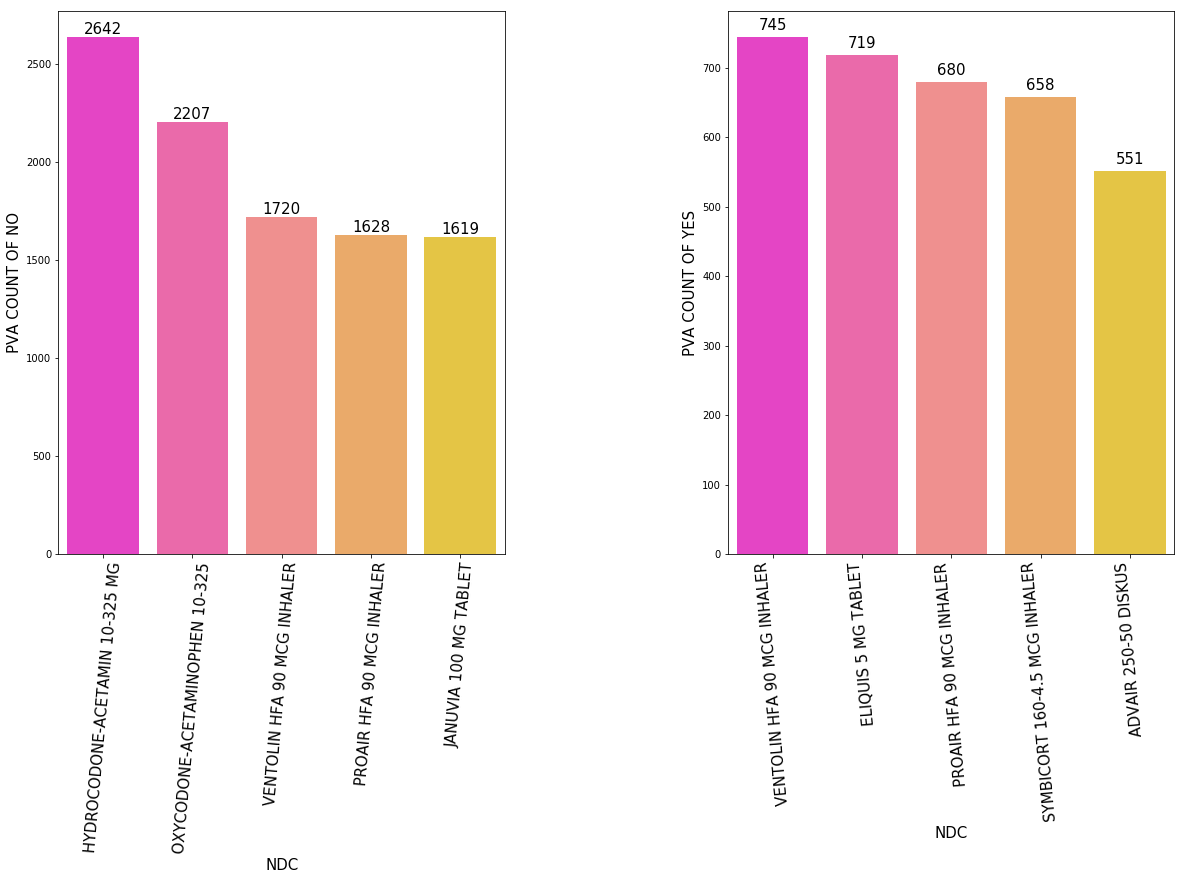

In [497]:
wksPVAAnalysis(listOfWeeks[0])



# Week 1 - 4 - PVA Analysis

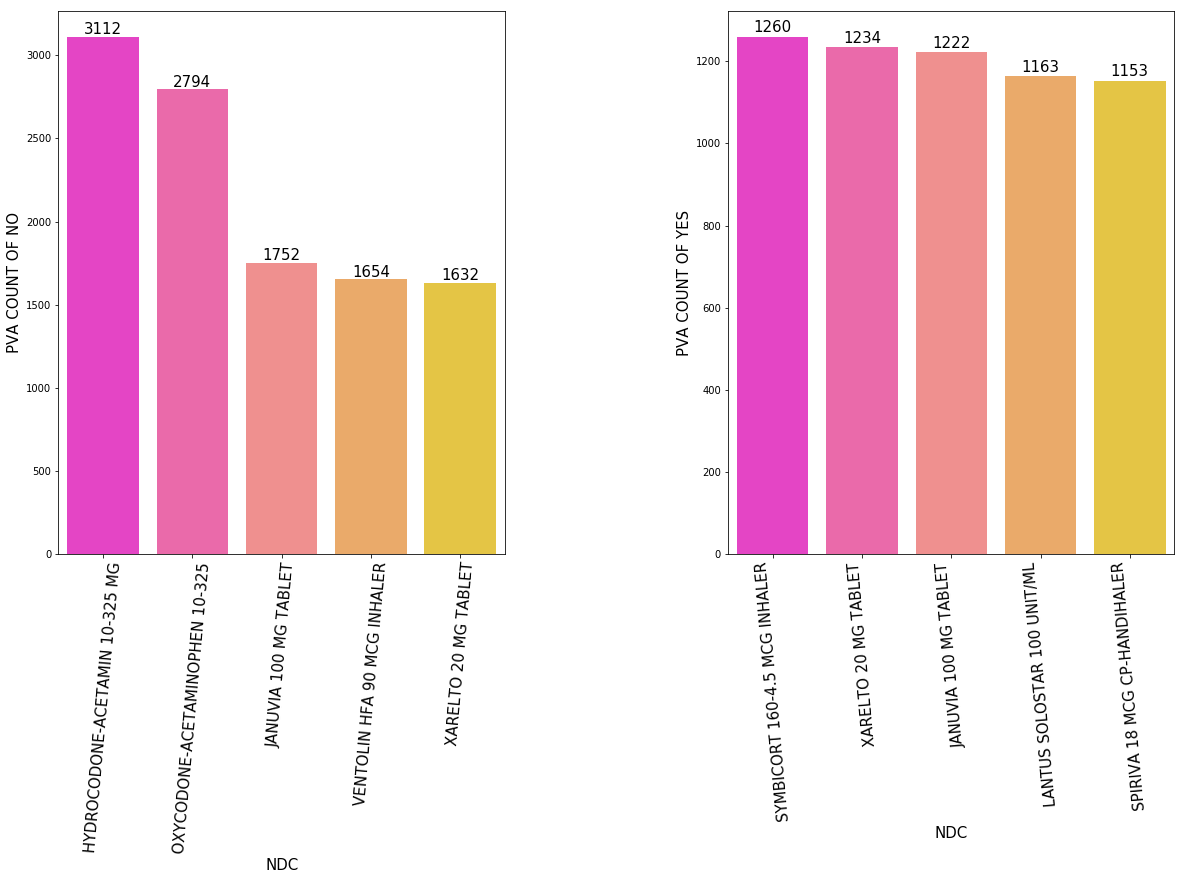

In [498]:
wksPVAAnalysis(listOfWeeks[1])

# Week 1-13  - PVA Analysis

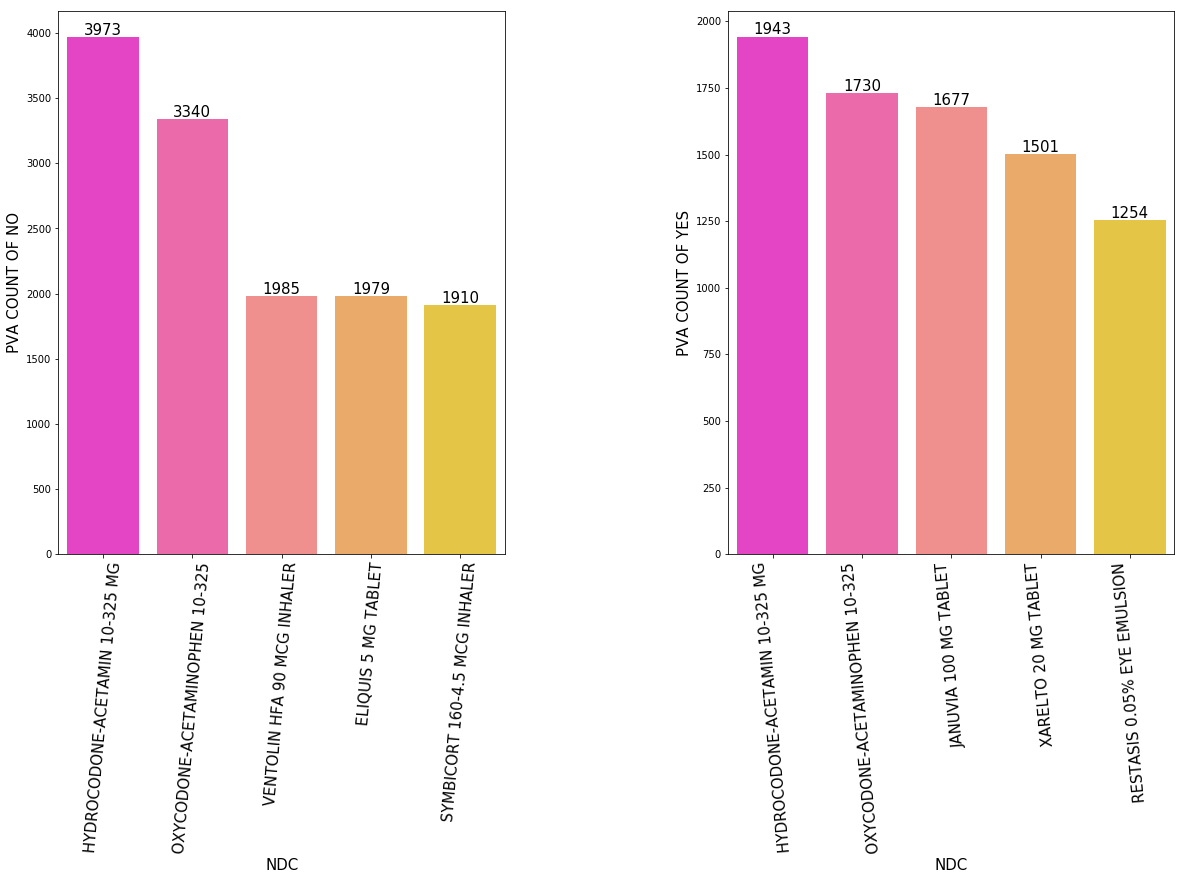

In [499]:
wksPVAAnalysis(listOfWeeks[2])

# Week 1-26  - PVA Analysis

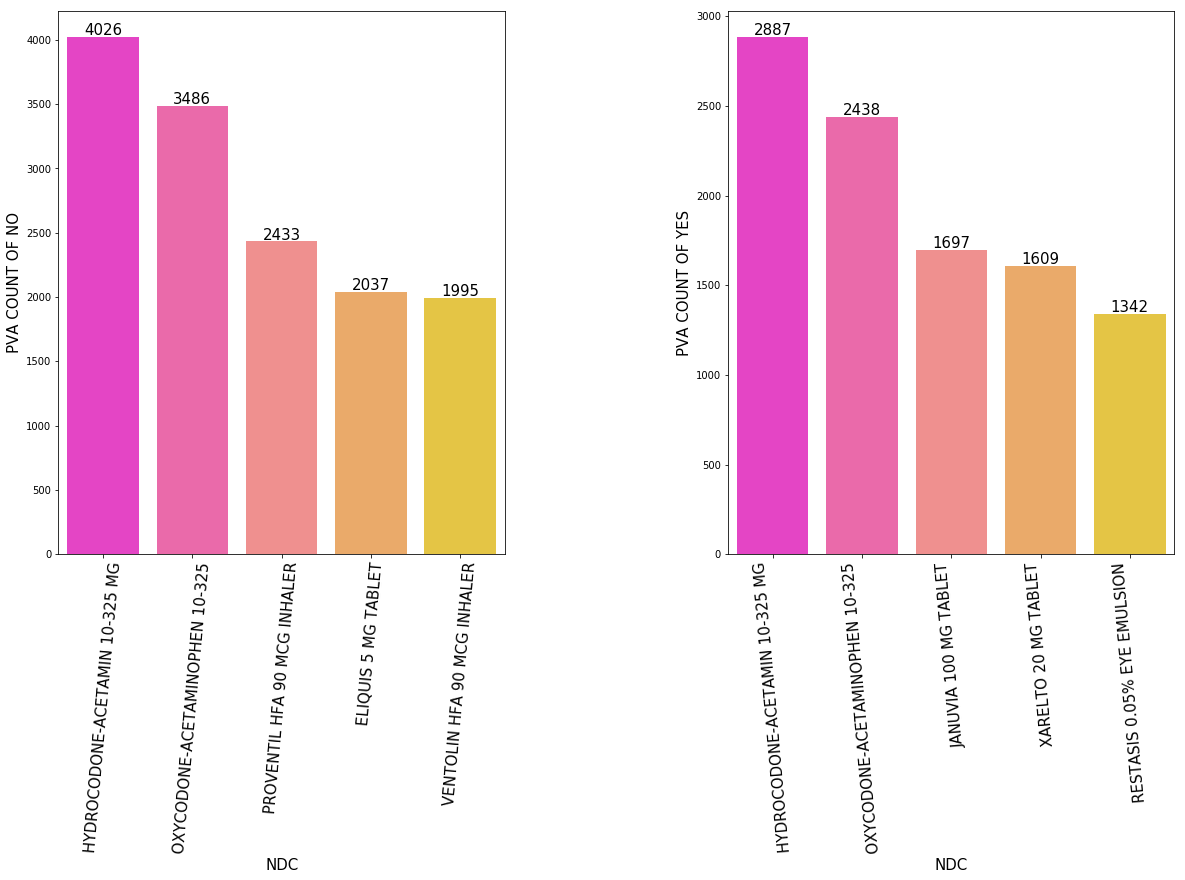

In [500]:
wksPVAAnalysis(listOfWeeks[3])

In [ ]:
# ANALYSE the cost per ndc with PVA status.Objective to find out whose cost is higher .Is is PVA or Non PVA

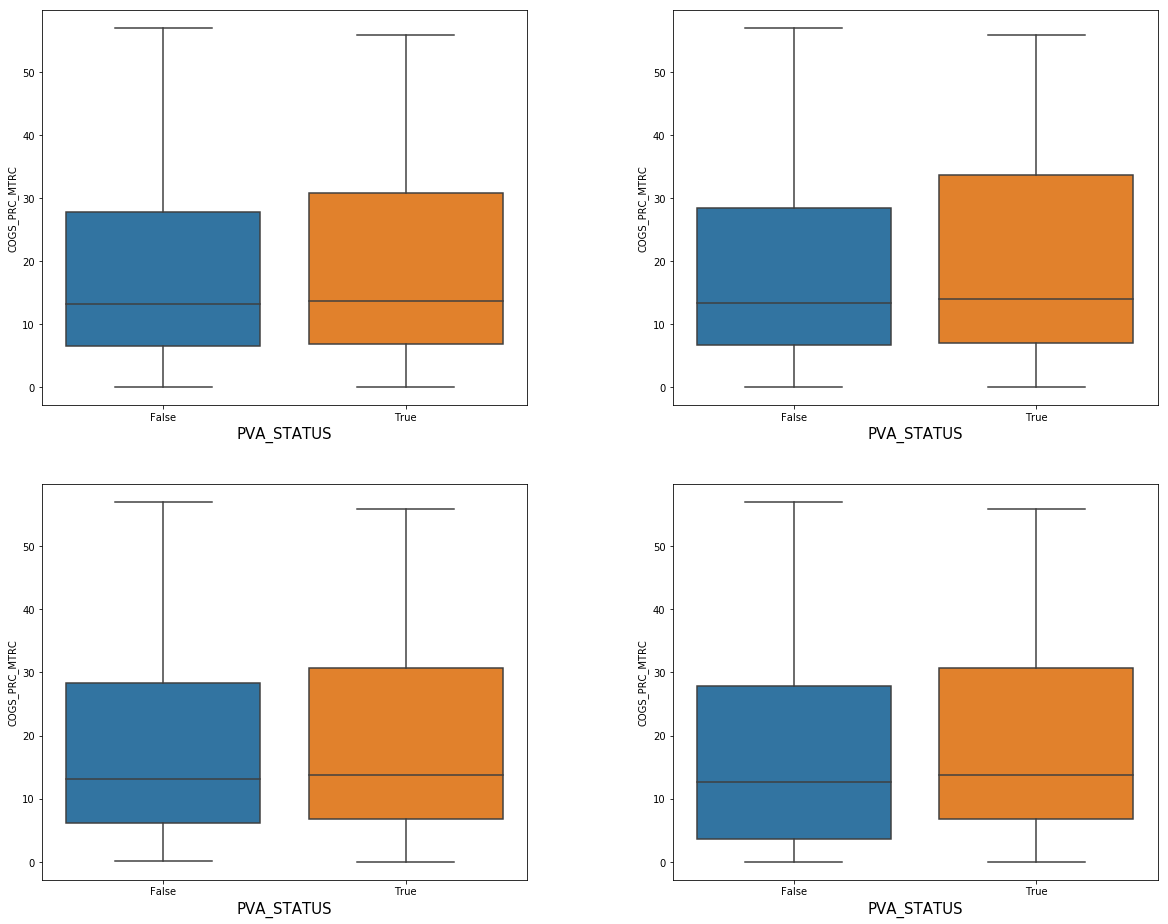

In [562]:
wk1df = X[wk1]
wks4df = X[wks4]
wks13df = X[wks13]
wks26df = X[wks26]
listOfWeeks=[wk1df,wks4df,wks13df,wks26df]
fig= plt.figure(figsize=(20,16))
fig.subplots_adjust(wspace=0.3)
def cogs(listOfWeeks):
    i=1
    for each in listOfWeeks:
        each = (each[(each.iloc[:,1] !=0.0) | (each.iloc[:,2] !=0.0)])
        diffCol = pd.DataFrame(each[each.columns.values[1]]/(each[each.columns.values[2]]))
        diffCol.columns=['wkDiff']
        #display(diffCol)
        each= pd.concat([each,diffCol],axis=1)
        each['PVA_Status'] = each['wkDiff'].apply(lambda x : x > 0.80 and x <1.2)
        each.reset_index(drop=True,inplace=True)
        if i < 5:
            ax=fig.add_subplot(2,2,i)
            ax = sns.boxplot(x= each['PVA_Status'],y=each['COGS_PRC_MTRC'],showfliers=False)
            ax.set_xlabel('PVA_STATUS',fontsize=15)
            i+=1
        
cogs(listOfWeeks)